# Chapter 12: QAOA

---

**Prerequisites:**
- Python 3.8+
- Qiskit 2.1.2
- See `Chapter02_Software.ipynb` for installation instructions


In [1]:
# Setup and imports
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms import QAOA
from qiskit_algorithms.optimizers import COBYLA, SLSQP, L_BFGS_B
from qiskit_ibm_runtime import SamplerV2
from qiskit_aer import Aer
from qiskit.primitives import StatevectorSampler 

from Chapter03_StructuralOptimization_functions import (truss1x1,truss1x2,truss2x2,
                                                    TrussFEM)
from Chapter12_QAOA_FLRS import QAOATrussOptimizerFLRS
from Chapter12_QAOA_Classic import QAOATrussOptimizer
print('Setup complete!')

Setup complete!


## Simple unconstrained QUBO

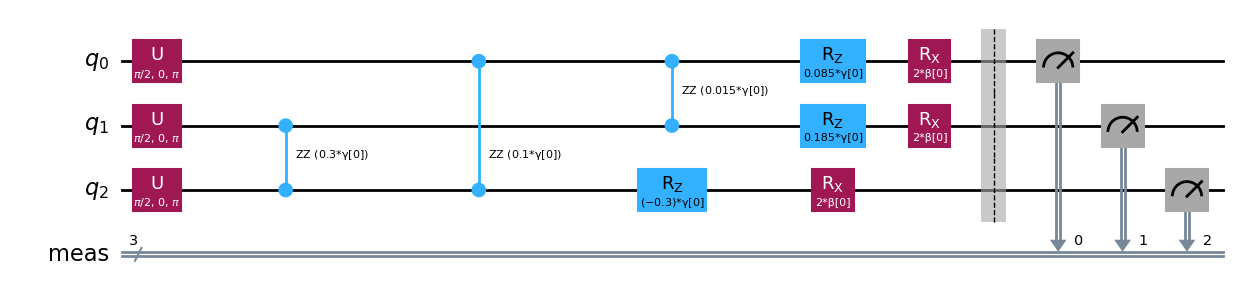

Optimal solution: a=0, b=1, c=1
Classical QUBO value: -0.6699999999999999


In [2]:
# QUBO: minimize 0.6ab + 0.2ac + 0.03bc - 0.1a - 0.5b - 0.2c
# Define cost Hamiltonian from QUBO
# After variable substitution x = (1-Z)/2
# H_C = 0.15 Z_0Z_1 + 0.05 Z_0Z_2 + 0.0075 Z_1Z_2 + h_0 Z_0 + h_1 Z_1 + h_2 Z_2 + C
cost_hamiltonian = SparsePauliOp.from_list([
    ("ZZI", 0.15), 
    ("ZIZ", 0.05), 
    ("IZZ", 0.0075),
    ("ZII", -0.15), 
    ("IZI", 0.0925),
    ("IIZ", 0.0425)     
])

qaoa = QAOA(
    sampler=StatevectorSampler(), # uses noiseless statevector simulator
    optimizer=COBYLA(maxiter=300)
)

result = qaoa.compute_minimum_eigenvalue(cost_hamiltonian)

optimal_circuit = result.optimal_circuit
display(optimal_circuit.decompose(reps=2).draw('mpl'))

# Extract optimal solution
optimal_bitstring = max(result.eigenstate, key=result.eigenstate.get)
a, b, c = [int(bit) for bit in optimal_bitstring]

print(f"Optimal solution: a={a}, b={b}, c={c}")

# Verify with classical QUBO evaluation
qubo_value = 0.6*a*b + 0.2*a*c + 0.03*b*c - 0.1*a - 0.5*b - 0.2*c
print(f"Classical QUBO value: {qubo_value}")

## Max-Cut with Constraints

In [3]:
"""
MAX-CUT QAOA with Constrained Mixer
====================================
Graph: 5 nodes with edges: (1,2), (1,3), (2,4), (3,4), (3,5), (4,5)
Constraint: Nodes 1 and 4 must be in DIFFERENT sets  q_0 + q_3 = 1

Convert to Hamiltonian:
minimize H_C = 0.5 * sum_{(i,j) in E} Z_i*Z_j
# Pauli convention: rightmost = qubit 0, leftmost = qubit 4
"""

cost_hamiltonian = SparsePauliOp.from_list([
    ("IIIZZ", 0.5),  
    ("IIZIZ", 0.5),  
    ("IZIZI", 0.5),  
    ("IZIIZ", 0.5),   
    ("ZIZII", 0.5), 
    ("ZZIII", 0.5),   
])

# ============================================================================
# Define Constrained Mixer: Preserves q_0 + q_3 = 1
# ============================================================================
# XY mixer for qubits 0 and 3 (nodes 1 and 4)
# Standard X mixer for qubits 1, 2, 4 (nodes 2, 3, 5)

mixer_hamiltonian = SparsePauliOp.from_list([
    ("IXIIX", 0.5),   # X_0*X_3 (XY mixer component)
    ("IYIIY", 0.5),   # Y_0*Y_3 (XY mixer component)
    ("IIIXI", 1.0),   # X_1 (standard mixer)
    ("IIXII", 1.0),   # X_2 (standard mixer)
    ("XIIII", 1.0),   # X_4 (standard mixer)
])

initial_state = QuantumCircuit(5)
initial_state.x(0)  # q_0=1, satisfies constraint q_0 + q_3 = 1
initial_state.h([1, 2, 4])  # Superposition on unconstrained qubits

qaoa = QAOA(
    sampler=StatevectorSampler(),
    optimizer=COBYLA(maxiter=200),
    initial_state=initial_state,
    mixer=mixer_hamiltonian,
    reps=1
)

result = qaoa.compute_minimum_eigenvalue(cost_hamiltonian)

optimal_bitstring = max(result.eigenstate, key=result.eigenstate.get)
q4, q3, q2, q1, q0 = [int(bit) for bit in optimal_bitstring]

print(f"Optimal bitstring: |{optimal_bitstring}>")

q_vec = np.array([q0, q1, q2, q3, q4])
cut_edges = []

indexed = [(1,2), (1,3), (2,4), (3,4), (3,5), (4,5)]
edges = [(i-1, j-1) for i, j in indexed]
for i, j in edges:
    if q_vec[i] != q_vec[j]:
        cut_edges.append((i+1, j+1))

print(f"Cut value: {len(cut_edges)}")
print(f"Constraint check: q_0 + q_3  = {q0+q3} ")


Optimal bitstring: |01100>
Cut value: 4
Constraint check: q_0 + q_3  = 1 


## Discrete truss optimization

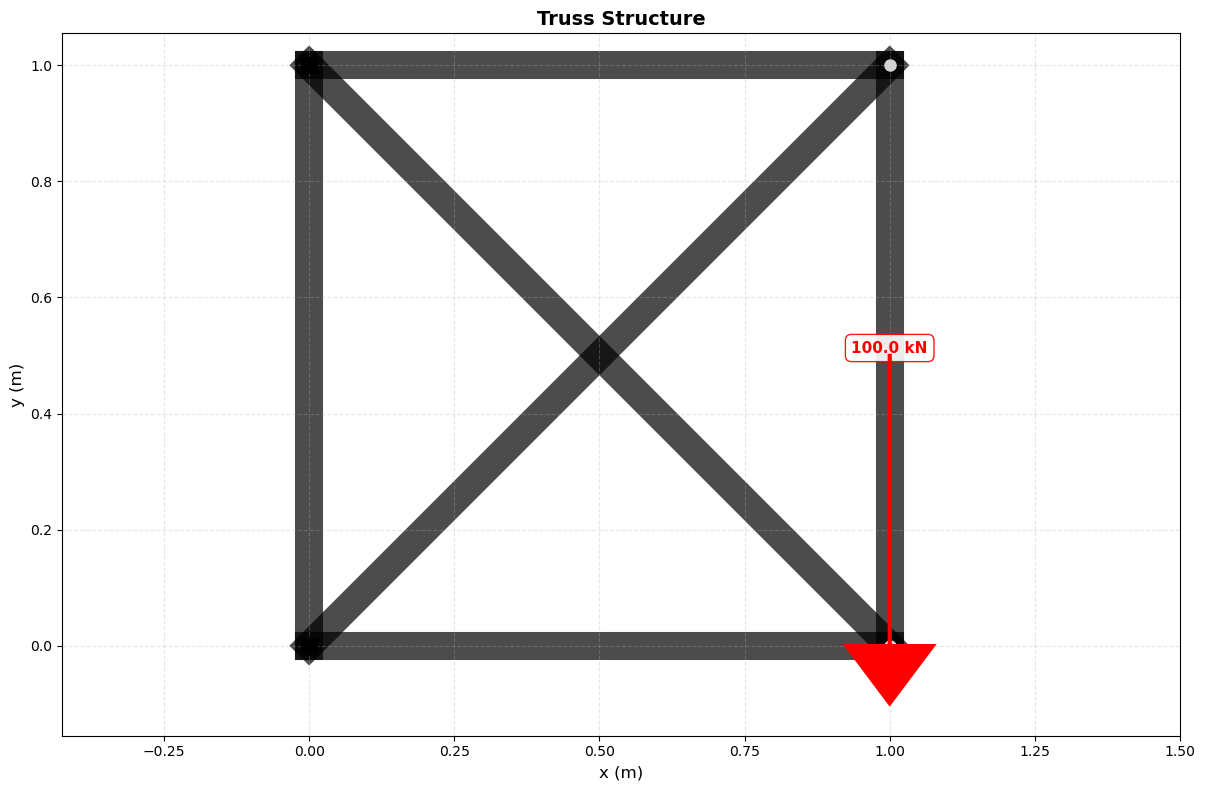

Initial design: Volume = 3.4142, Max Stress = 157757.7011


In [4]:
A0 = 0.5  # Initial cross-sectional area in m^2
fem_model = truss1x1(E=200e9, A=A0) # 
fem_model.plot_truss()
fem_model.solve()
metrics = fem_model.evaluate_design()
V0 = metrics['volume']

print(f"Initial design: Volume = {metrics['volume']:.4f}, Max Stress = {metrics['max_stress']:.4f}")


## QAOA optimizer for truss

Starting QAOA Optimization (7 qubits)...
Target Volume = 1.7071067811865475
Iter 1: Compliance=0.2135, Vol=3.073
Iter 2: Compliance=0.2373, Vol=2.766
Iter 3: Compliance=0.2636, Vol=2.489
Iter 4: Compliance=0.2929, Vol=2.24
Iter 5: Compliance=0.3255, Vol=2.016
Iter 6: Compliance=0.3616, Vol=1.814
Iter 7: Compliance=0.4018, Vol=1.836
Iter 8: Compliance=0.3794, Vol=1.818
Iter 9: Compliance=0.3713, Vol=1.823
Iter 10: Compliance=0.3584, Vol=1.741
Iter 11: Compliance=0.365, Vol=1.88
Iter 12: Compliance=0.3318, Vol=1.813
Iter 13: Compliance=0.3387, Vol=1.851
Iter 14: Compliance=0.322, Vol=1.788
Iter 15: Compliance=0.3296, Vol=1.804
Iter 16: Compliance=0.3163, Vol=1.837
Iter 17: Compliance=0.3012, Vol=1.813
Iter 18: Compliance=0.3025, Vol=1.724
Iter 19: Compliance=0.3137, Vol=1.784
Iter 20: Compliance=0.2954, Vol=1.862
Iter 21: Compliance=0.2766, Vol=1.867
Iter 22: Compliance=0.2752, Vol=1.761
Iter 23: Compliance=0.2865, Vol=1.879
Iter 24: Compliance=0.2646, Vol=1.719
Iter 25: Compliance=0.290

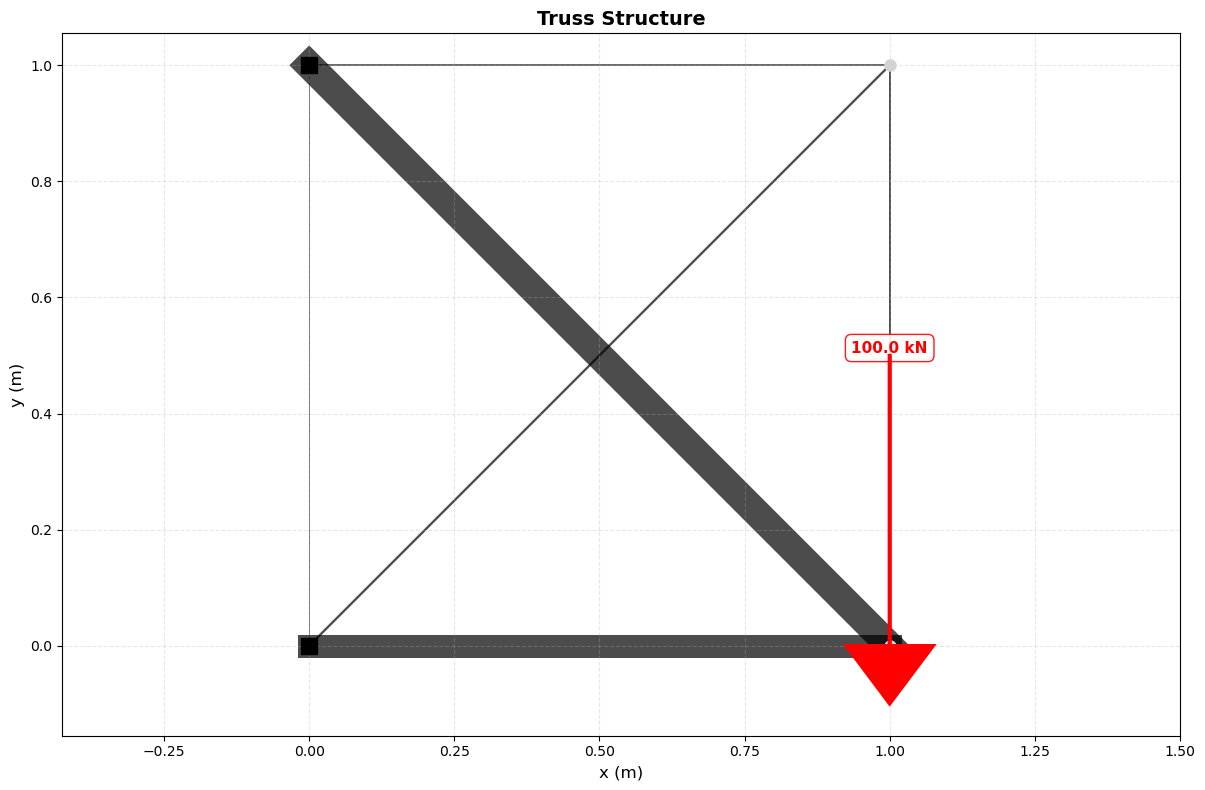

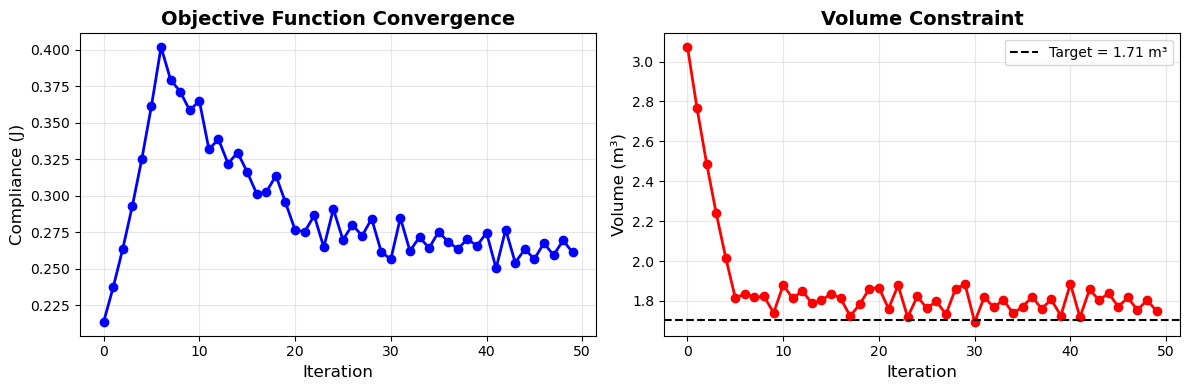

In [5]:
trussQAOA = QAOATrussOptimizer(
    fem_model=fem_model,
    V_bar=0.5*V0,             
    lambda_penalty=10,  
    p_layers = 4,
    max_iterations=50,
    verbose=True
)
results = trussQAOA.optimize()
fem_model.plot_truss()
trussQAOA.plot_convergence()
